In [2]:
from functools import partial

import torch
import torch.nn as nn
import numpy as np

import wandb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from model import NeuralGraph
from message import *
from update import *
from attention import *

/home/yegor/ngraph


/home/yegor/miniconda3/envs/yegor/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [212]:
DEVICE = 'cpu'
BS = 64
NODES = 4

ch_v = 8
ch_e = 8

# m_func = partial(message_tiny, ch_v, ch_e, zero=False)
# m_func = partial(message_tiny_plus, ch_v, ch_e, zero=False)
# m_func = partial(message_small, ch_v, ch_e, 8, zero=False)
# m_func = partial(message_small_plus, ch_v, ch_e, 8, zero=False)


# u_func = partial(update_tiny, ch_v, zero=False)
# u_func = partial(update_sigmoid_tiny, ch_v, zero=False)
# u_func = partial(update_small, ch_v, 8, zero=False)

m_func = lambda: nn.Sequential(
    nn.Linear(ch_v*2+ch_e, ch_v*2+ch_e),
    nn.ReLU(),
)

u_func = lambda: nn.Sequential(
    nn.Linear(ch_v*3, ch_v),
)

ngraph = NeuralGraph(
    NODES, m_func, u_func, None,
    connections = [(i, i+1) for i in range(NODES-1)],
    ch_v=ch_v, ch_e=ch_e,
    layers=1,
    batchsize=BS,
).to(DEVICE)

base_node = ngraph.node_vals.clone().detach()
base_edge = ngraph.edge_vals.clone().detach()
base_node.requires_grad_(True)
base_edge.requires_grad_(True)
None

In [213]:
STEPS = 1_000

criterion = nn.MSELoss()
params = [*ngraph.parameters(), base_node, base_edge]

optimizer = torch.optim.RMSprop(params, lr=1e-3, weight_decay=0.0)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS)
log = []

In [214]:
indices = list(range(0, len(X_data), BS))
np.random.shuffle(indices)
bar = tqdm(indices)

for (ahhh, i) in enumerate(bar):
    x = torch.randint(0, 2, size=(BS,), device=DEVICE).float()
    y = x

    
    # value_init='trainable_batch'
#     ngraph.node_vals = base_node + 0.0
#     ngraph.edge_vals = base_edge + 0.0

    # value_init='trainable'
    ngraph.node_vals = base_node[:1].expand(BS, -1, -1) + 0.0
    ngraph.edge_vals = base_edge[:1].expand(BS, -1, -1) + 0.0
    
    # value_init='random'
#     ngraph.node_vals = torch.randn_like(base_node) * 0.01
#     ngraph.edge_vals = torch.randn_like(base_edge) * 0.01
    
    ngraph.node_vals[:, 0, 0] = x
    for _ in range(10):
        for layer in range(len(ngraph.message)):
            ngraph.timestep(nodes=True, edges=True, layer=layer)
    
    pred = ngraph.node_vals[:, ngraph.nodes-1, 1]

    loss = criterion(pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, 1.0)
    optimizer.step()
    scheduler.step()

    mgrad = torch.norm(ngraph.message[0][0].weight.grad)
    ugrad = torch.norm(ngraph.update[0][0].weight.grad)
    node_grad = torch.norm(base_node.grad)
    edge_grad = torch.norm(base_edge.grad)
    
    entry = {
        'loss': loss.item(),
        'mgrad': mgrad.item(),
        'ugrad': ugrad.item(),
        'node_grad': node_grad.item(),
        'edge_grad': edge_grad.item(),
    }
    
    bar.set_postfix(entry)
    log.append(entry)
print(f'final loss: {loss.item():.4f}')

100%|████████████████████████| 1000/1000 [00:09<00:00, 101.69it/s, loss=0, mgrad=0, ugrad=0, node_grad=0, edge_grad=0]

final loss: 0.0000


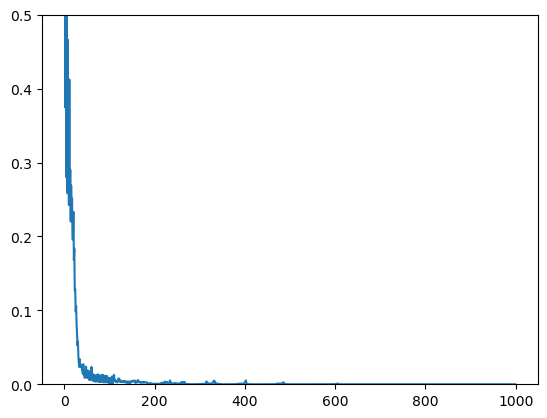

In [215]:
plt.plot([e["loss"] for e in log])
plt.ylim(0, 0.5)
plt.show()

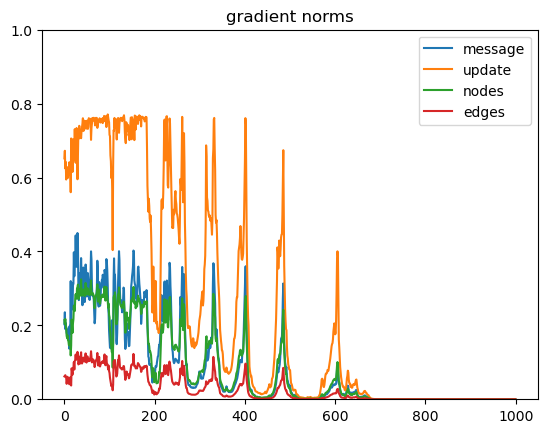

In [216]:
plt.plot([e["mgrad"] for e in log], label='message')
plt.plot([e["ugrad"] for e in log], label='update')
plt.plot([e["node_grad"] for e in log], label='nodes')
plt.plot([e["edge_grad"] for e in log], label='edges')
plt.title('gradient norms')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

In [ ]:
# torch.save(log, 'my_log.pt')